# Sentiment Analysis of Tweets about Brands (Apple & Google)

### Problem statement


This notebook builds an NLP model to classify sentiment in tweets directed at Apple and Google products.  


### Libraries

In [1]:
# pandas: for data handling
import pandas as pd

# re: Python's built-in library for regular expressions (used for text cleaning)
import re

# nltk: Natural Language Toolkit, useful for tokenization, stopword removal, and lemmatization
import nltk

import matplotlib.pyplot as plt

import seaborn as sns
nltk.download("punkt")        # tokenizer model

nltk.download("punkt_tab")    # sentence boundary detection

nltk.download("wordnet")      # lexical database for lemmatization 

nltk.download("omw-1.4")      # WordNet data for multiple languages

nltk.download("stopwords")    # common words to filter out (e.g., "the", "is")

# Import stopwords list from nltk (words to ignore during analysis)
from nltk.corpus import stopwords

# Import tokenizer to split text into individual words
from nltk.tokenize import word_tokenize

# Import lemmatizer to reduce words to their base form (e.g., "running" → "run")
from nltk.stem import WordNetLemmatizer

# TfidfVectorizer: convert text data into numerical features using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# train_test_split: split data into training and testing sets for model evaluation
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Data

In [2]:
# Reading the CSV file with correct encoding
df = pd.read_csv('Data/judge-1377884607_tweet_product_company.csv', encoding='Latin-1')

# Displaying the first 5 rows of the dataset
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Exploratory Data Analysis (EDA)

- In order to better understand the dataset and prepare it for sentiment analysis, we will focus on the following checks:
    - Preview the data: Inspect the first few rows to quickly grasp the dataset’s structure.
    - Detect any missing values in the data that could introduce bias or cause issues during preprocessing and modeling.
    - Identify and remove duplicate tweets to prevent overrepresentation of certain entries, which could distort the sentiment model.
    - Review the balance of sentiment categories, since skewed classes may result in models that favor majority classes and perform poorly on minority ones.

In [3]:
#shape of the data set
df.shape

(9093, 3)

In [4]:
# Basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


#### Duplicates

In [5]:
# Checking for duplicates and print how many there are
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows (excluding first occurrence): {num_duplicates}")

# Showing all rows that are duplicated, including their first occurrence
duplicates_with_originals = df[df.duplicated(keep=False)]

# Sorting so duplicates appear next to each other
duplicates_with_originals = duplicates_with_originals.sort_values(by=list(df.columns))

print("\nAll duplicate rows (including originals):")
duplicates_with_originals


Number of duplicate rows (excluding first occurrence): 22

All duplicate rows (including originals):


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
466,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
774,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
776,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
17,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion
8483,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion


### Basic Dataset Exploration

#### Sentiment Distribution

In [ ]:
# Get sentiment counts
sentiment_counts = df_cleaned['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
sentiment_counts

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

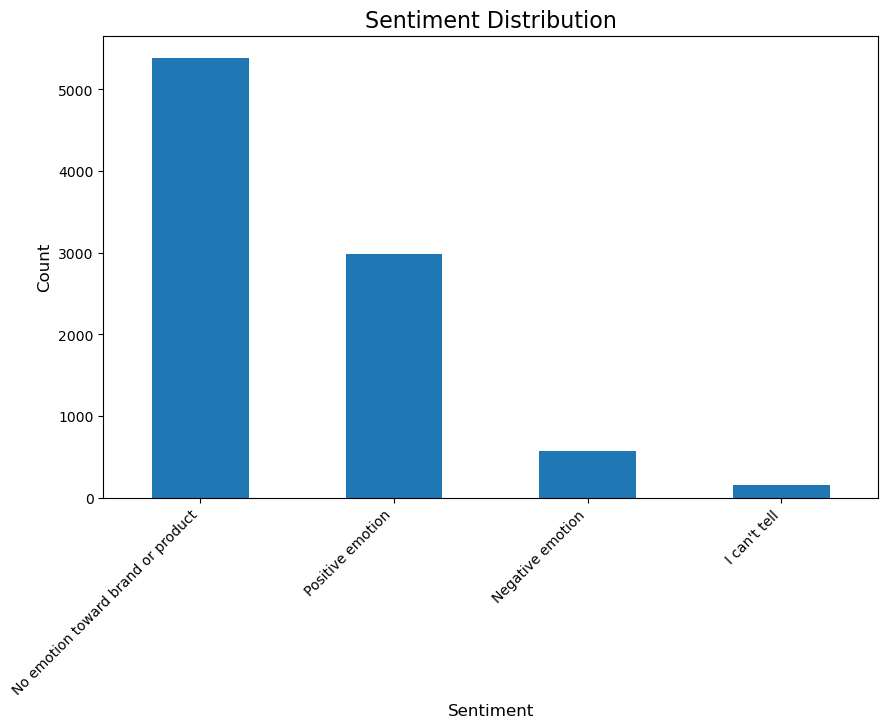

In [7]:
# Bar chart
plt.figure(figsize=(10,6))
sentiment_counts.plot(kind='bar')

plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


- Class imbalance exists, with Neutral (No-emotion) or positive emotion dominating and Negative being underrepresented.
    - The largest class is Neutral (No emotion toward brand or product) (5,375 tweets, ~54%).
    - The second largest is "Positive emotion" (2,970 tweets, ~30%).
    - "Negative emotion" is much smaller (569 tweets, ~6%).
    - "I can't tell" is very rare (156 tweets, ~2%).


#### Sentiment by Brand

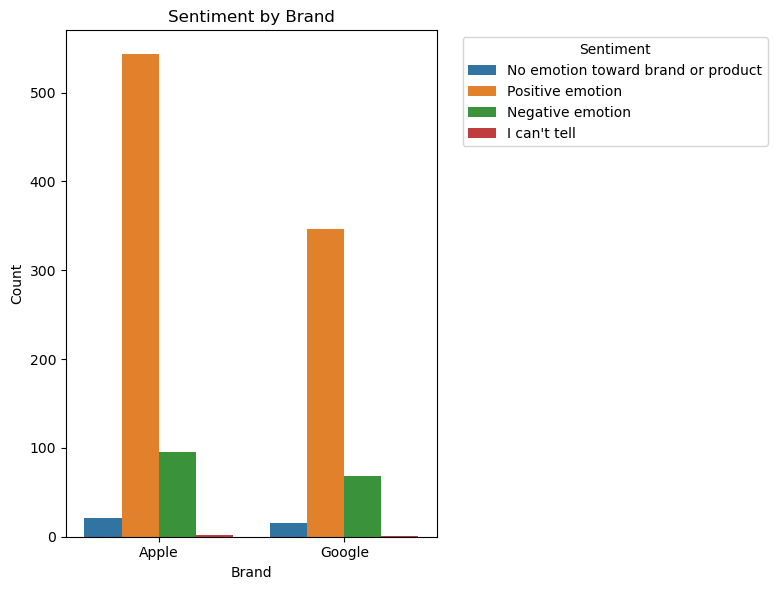

In [8]:
brands = ['Apple', 'Google']  # adjust if other brand names
subset = df[df['emotion_in_tweet_is_directed_at'].isin(brands)].copy()

plt.figure(figsize=(8,6))
hue_order = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().index.tolist()
sns.countplot(data=subset, x='emotion_in_tweet_is_directed_at', hue='is_there_an_emotion_directed_at_a_brand_or_product',
              order=brands, hue_order=hue_order)
plt.title('Sentiment by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
# plt.savefig('sentiment_by_brand.png', bbox_inches='tight')
plt.show()


- People on Twitter generally express clear opinions, mostly positive, when talking about these brands.
     - Public sentiment is mostly positive for both brands, with Apple slightly leading in volume.
    - Negative sentiment exists but is much smaller, and neutral/ambiguous tweets are rare.


## Cleaning and Preprocessing Text Data

- Preparing the tweet text for sentiment analysis by :
     - Removing URLs → eliminates links (e.g., http://..., https://..., www...) since they don’t contribute to sentiment.
     - Removing user mentions → strips out @username tags, which are not useful for sentiment content.
     - Removing hashtags → deletes #hashtag symbols and words, to prevent bias from hashtagged words.
     - Removing special characters and numbers → keeps only alphabetic characters and spaces.

- The purpose of this function is to standardize and clean the raw tweet text so that it’s easier to analyze. 

#### Tweet length distribution

- Checking tweet lengths in words and how they vary by sentiment.

- The distribution of tweet length shows that most tweets fall between 8 and 20 words, with a peak around 13–15 words.

- Tweets expressing positive (15.27) or negative emotions (16.19) tend to be slightly longer on average compared to neutral (14.32) or ambiguous tweets (14.92). This suggests that when users feel strongly about a brand or product, they use more words to convey their opinion.

- In contrast, tweets labeled as “I can’t tell” are shorter, indicating that uncertainty or lack of clear sentiment is often expressed more briefly. Outliers are also visible, particularly in neutral and negative tweets, where some users write much longer tweets, possibly rants or detailed explanations.

### Tokenization

- Creating a new column (tokens) which contains lists of individual words (tokens) from each cleaned tweet, enabling further text analysis and preprocessing.


### Stopward Removal

- Filtering out common English stopwords (like "the", "is", "at") from the tokens column to retain only meaningful words for analysis.

### Lemmatization

- Applying lemmatization to reduce words in the tokens column to their base or dictionary form (“running” → “run”, “cars” → “car”), which improves consistency in text analysis.

### Joining Tokens Back

- Converting lists of tokens back into full text strings (with words separated by spaces), so the cleaned and lemmatized tokens can be fed into models or vectorizers

#### Transformation Stages

- Lining up each stage of the preprocessing side by side so that it’s easy to trace how tweets evolve from their original form to the reconstructed processed string.
    - tweet_text → original
    - clean_text → after removing URLs, mentions, hashtags, special chars
    - tokens → after tokenization, stopword removal, and lemmatization
    - processed_text → final joined string

## Feature Engineering

###  Vectorization (TF-IDF Example)

- Transforming cleaned tweets into machine-readable numbers for modeling while limiting the vocabulary size to 5,000 features.

# Define target labels (sentiment)
y = df["is_there_an_emotion_directed_at_a_brand_or_product"]

# Use the TF-IDF features from the preprocessing pipeline
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


- Examining how TF-IDF represents an individual tweet numerically.
    - Select a sample tweet, in our case we choose the first one
    - Convert it's sparse TF-IDF vector into readable dense format
    - Identify the non-zero features — i.e., the words that appear in this tweet.
    - Pair each word with its corresponding TF-IDF weight.

- The output showcases: 
    - the original tweet
    - the cleaned and processed version
    - and the key words with their TF-IDF scores that define the tweet’s representation.

## Model Building

### Train-Test Split

- Splitting the dataset into training (80%) and testing (20%) sets to prepare for model building.
- The training set (X_train, y_train) will be used to fit the model, while the test set (X_test, y_test) will evaluate its performance.

## Refactoring the steps above into a Pipeline
### Building a Custom Text Preprocessing Pipeline

- We refactored preprocessing into a Scikit-learn Pipeline to ensure consistent and reproducible text processing across all tweets by creating a custom TextPreprocessor that handles:
  - Removal of URLs, mentions, hashtags, and special characters
  - Tokenization, stopword removal, and lemmatization
  - Filling in missing text values


In [49]:
import pandas as pd
import re
import nltk
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources (leave commented if already downloaded)
# nltk.download("punkt")
# nltk.download("stopwords")
# nltk.download("wordnet")
# nltk.download("omw-1.4")
# nltk.download("vader_lexicon")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

# -------------------------------
# Custom Preprocessor
# -------------------------------
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def clean_text(self, text):
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove urls
        text = re.sub(r"@\w+", "", text)  # remove mentions
        text = re.sub(r"#\w+", "", text)  # remove hashtags
        text = re.sub(r"[^A-Za-z\s]", "", text)  # remove special characters
        return text.strip()
    
    def tokenize_lemmatize(self, text):
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t.lower() not in stop_words]
        tokens = [lemmatizer.lemmatize(t.lower()) for t in tokens]
        return " ".join(tokens)
    
    def transform(self, X, y=None):
        X_filled = X.copy()
        # Only process text, do not drop/fill missing values here
        X_filled[self.text_column] = X_filled[self.text_column].astype(str).apply(
            lambda t: self.tokenize_lemmatize(self.clean_text(t))
        )
        return X_filled

    def fit(self, X, y=None):
        return self

# -------------------------------
# Feature Engineering Transformer
# -------------------------------
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def transform(self, X, y=None):
        df = X.copy()
        text_data = df[self.text_column]

        # Numeric features
        features = pd.DataFrame({
            "tweet_length": text_data.apply(len),
            "word_count": text_data.apply(lambda t: len(t.split())),
            "avg_word_len": text_data.apply(lambda t: (sum(len(w) for w in t.split()) / (len(t.split()) + 1e-6))),
            "unique_word_ratio": text_data.apply(lambda t: len(set(t.split())) / (len(t.split()) + 1e-6)),
            "num_mentions": text_data.apply(lambda t: len(re.findall(r"@\w+", t))),
            "num_hashtags": text_data.apply(lambda t: len(re.findall(r"#\w+", t))),
        })

        # Sentiment scores
        sentiment = text_data.apply(lambda t: sia.polarity_scores(t))
        sentiment_df = pd.DataFrame(list(sentiment))  # compound, pos, neu, neg

        return pd.concat([features, sentiment_df], axis=1).values

    def fit(self, X, y=None):
        return self

# -------------------------------
# Load Dataset
# -------------------------------
df = pd.read_csv("Data/judge-1377884607_tweet_product_company.csv", encoding="Latin-1")

# Clean DataFrame before pipeline: drop missing and duplicate tweet_text
df_cleaned = df.dropna(subset=["tweet_text"]).drop_duplicates(subset=["tweet_text"])
df_cleaned["emotion_in_tweet_is_directed_at"] = df_cleaned["emotion_in_tweet_is_directed_at"].fillna("Unknown")

# Apply text preprocessing to get processed text
text_preprocessor = TextPreprocessor(text_column="tweet_text")
df_processed = text_preprocessor.transform(df_cleaned)

# Drop rows where processed tweet_text is empty after cleaning
df_final = df_processed[df_processed["tweet_text"].str.strip() != ""]

# -------------------------------
# Final Pipeline: Text + Numeric Features
# -------------------------------
preprocessing_pipeline = Pipeline([
    ("text_preprocessor", TextPreprocessor(text_column="tweet_text")),
    ("features", FeatureUnion(transformer_list=[
        # TF-IDF text representation
        ("tfidf", Pipeline([
            ("to_text", FunctionTransformer(lambda d: d["tweet_text"], validate=False)),
            ("tfidf", TfidfVectorizer(max_features=5000))
        ])),
        # Numeric engineered features
        ("engineered", Pipeline([
            ("eng", FeatureEngineer(text_column="tweet_text")),
            ("scaler", StandardScaler())
        ]))
    ]))
])

# Apply pipeline to fully cleaned DataFrame
X_features = preprocessing_pipeline.fit_transform(df)
print("Final feature matrix shape:", X_features.shape)

Final feature matrix shape: (9093, 5010)


In [50]:
import numpy as np

# -------------------------------
# Inspect Pipeline Outputs
# -------------------------------

# 1. Get TF-IDF feature names
tfidf_vectorizer = preprocessing_pipeline.named_steps["features"].transformer_list[0][1].named_steps["tfidf"]
tfidf_features = tfidf_vectorizer.get_feature_names_out()

# 2. Define engineered feature names
engineered_feature_names = [
    "tweet_length", "word_count", "avg_word_len", "unique_word_ratio",
    "num_mentions", "num_hashtags", "sent_compound", "sent_pos", "sent_neu", "sent_neg"
]

# 3. Combine all feature names
all_feature_names = np.concatenate([tfidf_features, engineered_feature_names])

print("Total features:", len(all_feature_names))
print("First 20 features:", all_feature_names[:20])  # peek

# 4. Turn the transformed feature matrix into a DataFrame for inspection
X_features_df = pd.DataFrame(X_features.toarray() if hasattr(X_features, "toarray") else X_features,
                             columns=all_feature_names)

# Preview first rows
print(X_features_df.head())


Total features: 5010
First 20 features: ['aapl' 'aaron' 'ab' 'abba' 'abc' 'ability' 'able' 'abnormal' 'absolutely'
 'absolutley' 'abt' 'abuzz' 'academy' 'acc' 'accelerater' 'acceptable'
 'access' 'accessibility' 'accessible' 'accessory']
   aapl  aaron   ab  abba  abc  ability  able  abnormal  absolutely  \
0   0.0    0.0  0.0   0.0  0.0      0.0   0.0       0.0         0.0   
1   0.0    0.0  0.0   0.0  0.0      0.0   0.0       0.0         0.0   
2   0.0    0.0  0.0   0.0  0.0      0.0   0.0       0.0         0.0   
3   0.0    0.0  0.0   0.0  0.0      0.0   0.0       0.0         0.0   
4   0.0    0.0  0.0   0.0  0.0      0.0   0.0       0.0         0.0   

   absolutley  ...  tweet_length  word_count  avg_word_len  unique_word_ratio  \
0         0.0  ...     -0.284427   -0.171383     -0.325853           0.415491   
1         0.0  ...      1.217289    1.096626      0.282503           0.415491   
2         0.0  ...     -2.173682   -2.073396     -1.455658           0.415486   
3         0

C:\Users\user\AppData\Local\Temp\ipykernel_13932\2302166391.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_terms, x="tfidf", y="term", palette="viridis")


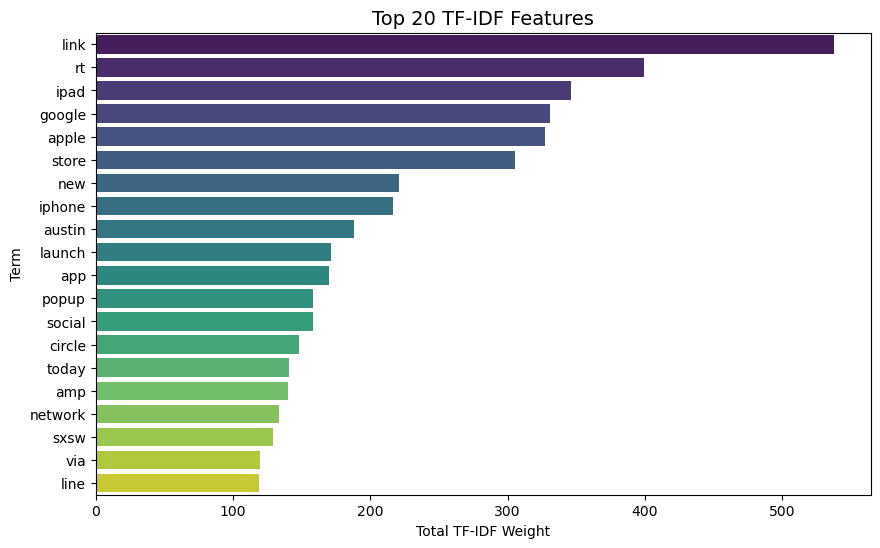

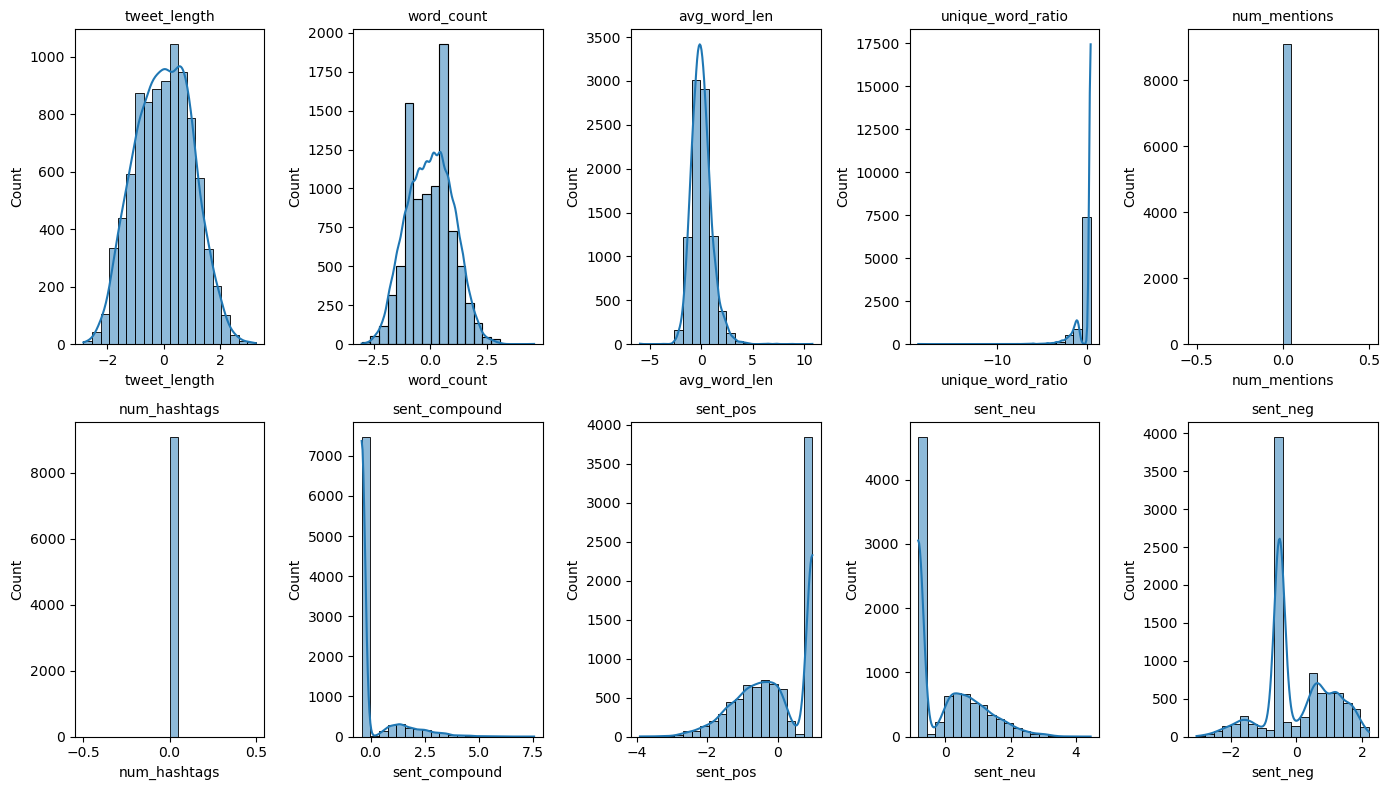

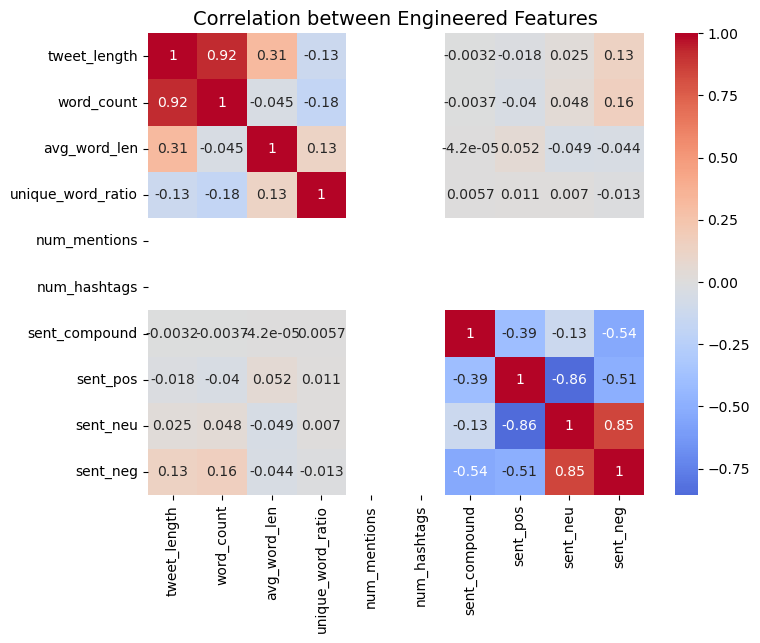

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Top TF-IDF Features
# -------------------------------
def plot_top_tfidf_features(tfidf_vectorizer, X_tfidf, top_n=20):
    # Sum TF-IDF values across all documents
    sums = X_tfidf.sum(axis=0).A1
    terms = tfidf_vectorizer.get_feature_names_out()
    data = pd.DataFrame({"term": terms, "tfidf": sums})
    top_terms = data.sort_values("tfidf", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_terms, x="tfidf", y="term", palette="viridis")
    plt.title(f"Top {top_n} TF-IDF Features", fontsize=14)
    plt.xlabel("Total TF-IDF Weight")
    plt.ylabel("Term")
    plt.show()

# Call it
tfidf_vectorizer = preprocessing_pipeline.named_steps["features"].transformer_list[0][1].named_steps["tfidf"]
X_tfidf = preprocessing_pipeline.named_steps["features"].transformer_list[0][1].transform(df_final)
plot_top_tfidf_features(tfidf_vectorizer, X_tfidf, top_n=20)

# -------------------------------
# 2. Engineered Feature Distributions
# -------------------------------
def plot_engineered_features(X_features_df, engineered_feature_names):
    plt.figure(figsize=(14, 8))
    for i, col in enumerate(engineered_feature_names, 1):
        plt.subplot(2, 5, i)  # 2 rows x 5 cols
        sns.histplot(X_features_df[col], kde=True, bins=20)
        plt.title(col, fontsize=10)
        plt.tight_layout()
    plt.show()

plot_engineered_features(X_features_df, engineered_feature_names)

# -------------------------------
# 3. Correlation Heatmap (engineered features only)
# -------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(X_features_df[engineered_feature_names].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Engineered Features", fontsize=14)
plt.show()


In [54]:
# -------------------------------
# Define features and target
# -------------------------------
X = df[["tweet_text"]]   # features (just the text column, pipeline handles processing)
y = df["is_there_an_emotion_directed_at_a_brand_or_product"]  # adjust target column if needed

# -------------------------------
# Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keep class distribution balanced
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 7274
Test size: 1819


# Model Building starts here